In [1]:
from networkx.algorithms.tree.mst import SpanningTreeIterator
import matplotlib.pyplot as plt
import tree_utils as tu
from tqdm import tqdm
import networkx as nx
import numpy as np
import random

In [2]:
def generate_grid_graph(N):
    g = nx.grid_graph(dim=(N,N))
    # nx.relabel_nodes(g, {node: (N * node[0]) + node[1] + 1 for node in g.nodes}, copy=False)
    for edge in g.edges:
        u, v = edge
        g[u][v]['weight'] = 1
    return g

def enumerate_all_trees(g):
    trees = SpanningTreeIterator(g)
    trees = []
    for tree in tqdm(SpanningTreeIterator(g)):
        trees.append(tree)
    return trees

def sample_trees(g, func, N):
    trees = []
    for _ in tqdm(range(N)):
        tree = func(g)
        trees.append(tree)
    return trees

def make_tree_dict(trees, ds):
    tree_dict = {}
    for tree in tqdm(trees):
        d_dict = {}
        for d in ds:
            d_dict[d] = tu.find_balance_edge(tree, d)
        tree_dict[tree] = d_dict
    return tree_dict

def make_counting_dict(g, tree_dict, ds):
    counting_dict = {}
    for d in ds:
        counting_dict[d] = {e: 0 for e in g.edges}
        for tree in tqdm(tree_dict):
            balance_edges = tree_dict[tree][d]
            for balance_edge in balance_edges:
                counting_dict[d][balance_edge] += 1
    return counting_dict

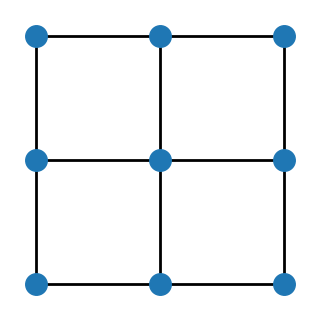

In [3]:
g = generate_grid_graph(3) 
tu.draw(g)

In [4]:
num_trees = 1000
ust_trees = sample_trees(g, tu.uniform_random_spanning_tree, num_trees)
mst_trees = sample_trees(g, tu.random_minimum_spanning_tree, num_trees)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1714.35it/s]


In [5]:
%%time
ds = [0, 1, 2]
ust_tree_dict = make_tree_dict(ust_trees, ds)
ust_counting_dict = make_counting_dict(g, ust_tree_dict, ds)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 280592.99it/s]

CPU times: user 2.08 s, sys: 55.9 ms, total: 2.13 s
Wall time: 2.13 s


In [6]:
%%time
ds = [0, 1, 2]
mst_tree_dict = make_tree_dict(mst_trees, ds)
mst_counting_dict = make_counting_dict(g, mst_tree_dict, ds)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 388038.12it/s]

CPU times: user 2.13 s, sys: 54.8 ms, total: 2.18 s
Wall time: 2.23 s


In [7]:
def plot(g, attention, ax, nodes_to_plot=None, nodes_labels=None,
         edges_to_plot=None, nodes_pos=None, nodes_colors=None,
         edge_colormap=plt.cm.Reds):
    """
    Visualize edge attentions by coloring edges on the graph.
    g: nx.DiGraph
        Directed networkx graph
    attention: list
        Attention values corresponding to the order of sorted(g.edges())
    ax: matplotlib.axes._subplots.AxesSubplot
        ax to be used for plot
    nodes_to_plot: list
        List of node ids specifying which nodes to plot. Default to
        be None. If None, all nodes will be plot.
    nodes_labels: list, numpy.array
        nodes_labels[i] specifies the label of the ith node, which will
        decide the node color on the plot. Default to be None. If None,
        all nodes will have the same canonical label. The nodes_labels
        should contain labels for all nodes to be plot.
    edges_to_plot: list of 2-tuples (i, j)
        List of edges represented as (source, destination). Default to
        be None. If None, all edges will be plot.
    nodes_pos: dictionary mapping int to numpy.array of size 2
        Default to be None. Specifies the layout of nodes on the plot.
    nodes_colors: list
        Specifies node color for each node class. Its length should be
        bigger than number of node classes in nodes_labels.
    edge_colormap: plt.cm
        Specifies the colormap to be used for coloring edges.
    """
    if nodes_to_plot is None:
        nodes_to_plot = sorted(g.nodes())
    if edges_to_plot is None:
        # assert isinstance(g, nx.DiGraph), 'Expected g to be an networkx.DiGraph' \
        #                                   'object, got {}.'.format(type(g))
        edges_to_plot = sorted(g.edges())
    nx.draw_networkx_edges(g, nodes_pos, edgelist=edges_to_plot,
                           edge_color=attention, edge_cmap=edge_colormap,
                           width=2, alpha=0.5, ax=ax, edge_vmin=0,
                           edge_vmax=1)

    if nodes_colors is None:
        nodes_colors = sns.color_palette("deep", max(nodes_labels) + 1)

    nx.draw_networkx_nodes(g, nodes_pos, nodelist=nodes_to_plot, ax=ax, node_size=30,
                           node_color=[nodes_colors[nodes_labels[v - 1]] for v in nodes_to_plot],
                           with_labels=False, alpha=0.9)

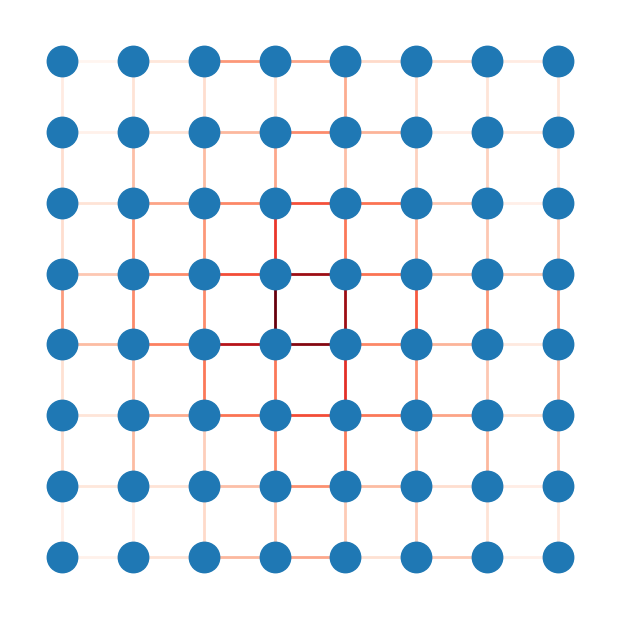

In [ ]:
N = 6
plt.figure(figsize=(N,N)) # this is needed to keep aspect ratio correct
plt.tight_layout()
nx.draw(g, 
        pos={(x,y): (x, y) for x,y in g.nodes()},
        width=2,
        with_labels=False,
        node_size=80*N,
        edge_color=[ust_counting_dict[0][e] for e in g.edges()],
        edge_cmap=plt.cm.Reds
       )
# sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds)#, norm=plt.Normalize(vmin=0, vmax=1))
# sm.set_array([])
# plt.colorbar(sm, fraction=0.046, pad=0.01)
# plt.show()
plt.savefig("plots/8x8_u100k.png", dpi=300, bbox_inches='tight')

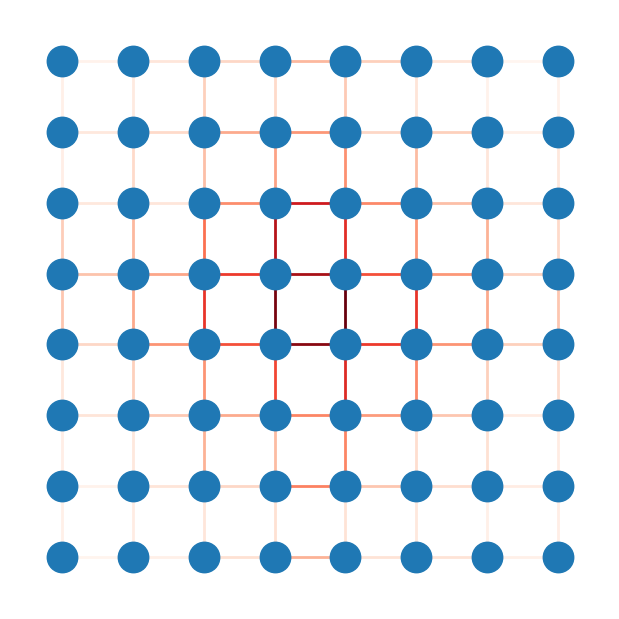

In [37]:
N = 6
plt.figure(figsize=(N,N)) # this is needed to keep aspect ratio correct
plt.tight_layout()
nx.draw(g, 
        pos={(x,y): (x, y) for x,y in g.nodes()},
        width=2,
        with_labels=False,
        node_size=80*N,
        edge_color=[mst_counting_dict[0][e] for e in g.edges()],
        edge_cmap=plt.cm.Reds
       )
# sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds)#, norm=plt.Normalize(vmin=0, vmax=1))
# sm.set_array([])
# plt.colorbar(sm, fraction=0.046, pad=0.01)
plt.savefig("plots/8x8_m100k.png", dpi=300, bbox_inches='tight')
# plt.show()

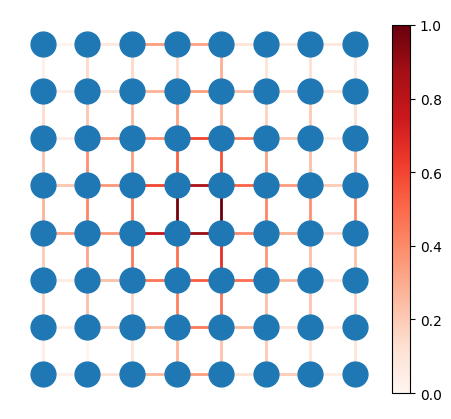

In [45]:
plt.figure(figsize=(N/2,N/2)) # this is needed to keep aspect ratio correct
plt.tight_layout()
nx.draw(g, 
        pos={(x,y): (x, y) for x,y in g.nodes()},
        width=2,
        with_labels=False,
        node_size=80*N/2,
        edge_color=[counting_dict[0][e] for e in g.edges()],
        edge_cmap=plt.cm.Reds
       )
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds)#, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
plt.colorbar(sm, fraction=0.046, pad=0.01)
plt.show()

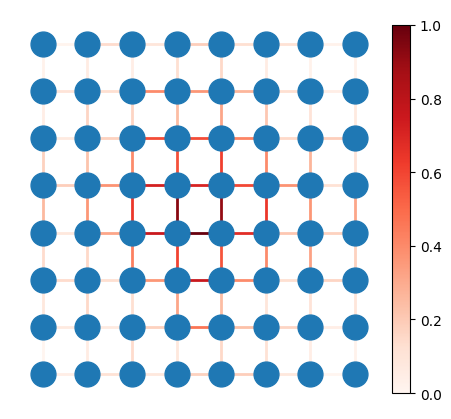

In [46]:
plt.figure(figsize=(N/2,N/2)) # this is needed to keep aspect ratio correct
plt.tight_layout()
nx.draw(g, 
        pos={(x,y): (x, y) for x,y in g.nodes()},
        width=2,
        with_labels=False,
        node_size=80*N/2,
        edge_color=[mst_counting_dict[0][e] for e in g.edges()],
        edge_cmap=plt.cm.Reds
       )
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds)#, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
plt.colorbar(sm, fraction=0.046, pad=0.01)
plt.show()

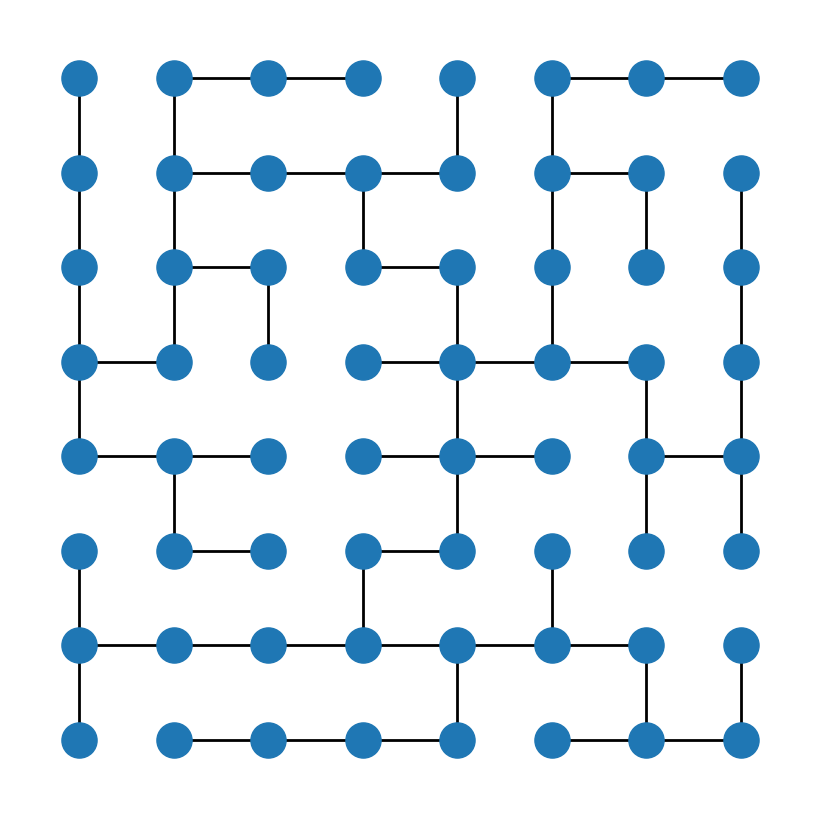

KeyboardInterrupt: 

In [41]:
d = 2
for tree in ust_tree_dict:
    for u, v, data in tree.edges(data=True):
        if (u,v) in ust_tree_dict[tree][d]:
            data['colors'] = 'red'
        else:
            data['colors'] = 'black'
    tu.draw(tree, edge_colors='c', delay=1)

In [93]:
sum(counting_dict[0].values())

53440

In [98]:
# two fractions could be interesting :
#    divide with number of spanning trees that have balance edges 
#    divide with number of spanning trees 

In [106]:
# this is normalized by the number of spanning trees
normalized_counting_dict = [counting_dict[0][e]/len(trees) for e in g.edges()] 
normalized_counting_dict

[0.008978396045918368,
 0.008978396045918368,
 0.014718191964285714,
 0.03515625,
 0.014718191964285714,
 0.008978396045918368,
 0.008978396045918368,
 0.03515625,
 0.014718191964285714,
 0.05058195153061224,
 0.05058195153061224,
 0.05058195153061224,
 0.014718191964285714,
 0.03515625,
 0.008978396045918368,
 0.014718191964285714,
 0.014718191964285714,
 0.05058195153061224,
 0.014718191964285714,
 0.014718191964285714,
 0.008978396045918368,
 0.008978396045918368,
 0.03515625,
 0.008978396045918368]